In [100]:
#Import modules

import pandas as pd
import requests
import numpy as np
import json
from dotenv import load_dotenv
import sys
import os
from alpaca_trade_api.rest import TimeFrame, URL
import alpaca_trade_api as tradeapi
import pytz
import datetime as dt
import hvplot.pandas
import panel as pn
from utils import MonteCarloFunctions as mcf
from utils import AlpacaFunctions as apf
import datetime as dt
import hvplot
import hvplot.pandas
import matplotlib.pyplot as plt
import plotly as pty
import plotly.express as px
import bokeh



**Below we are going to define functions we will be using repeatedly within the project -- will probably need to be moved to a separate .py file in order to "modularize" our app.  We will then be able to import the relevant functions from the separate file.

In [101]:
#Establish ARK API variables -- base url for api calls, request type i.e. profile, trades, etc., etf_symbol for desired etf and additional arguments as parameters
 
holdings_symbol = 'ARKK'
holdings_url = 'https://arkfunds.io/api/v2/etf/holdings'  

#Initial API call to establish current positions for ARKK
# need to code for an error response if API call is unsuccessfsul i.e. if response.status_code == 200:
response = requests.get(holdings_url, params = {'symbol' : 'ARKK'}).json()
#print(json.dumps(response, indent=4, sort_keys=True))

**Something for us to consider -- would it be better to utilize dataframes or databases to manipulate and analyze our data?

In [102]:
# We want to create a dataframe with the relevant 'holdings' data from the json object returned above
initial_holdings_df = pd.DataFrame(response['holdings']).dropna(axis=0)
#display(holdings_df)

#Check to confirm we have dropped null values in our DataFrame
display(initial_holdings_df.isnull().sum())


fund            0
date            0
ticker          0
company         0
cusip           0
shares          0
market_value    0
share_price     0
weight          0
weight_rank     0
dtype: int64

**To be done for project -- we need to find a solution for null values in our holdings dataframe as it could change and we do not necessarily want to have to dig in and figure out which value is null and what belongs there... possibly create an if/then statement for null values and how to handle them i.e. alert the user of the null value and provide options for  how to handle it.  For the purposes of our MVP, we are going to drop rows with null values since the recurring null value is for a ticker with very little impact on the portfolio.  For future consideration would be a more elegant way to handle null values, but for now we will simply drop them.  NOTE:  this will cause our weights to not equal 100, thus we must rebalance the weights so we can run our calculations.

In [103]:
# For our purposes we want to focus on the 'ticker','weight', and 'company' columns of the dataframe.  This will allow us to perform historical research with the Alpaca API as well as plot the weights of the portfolio stocks.
initial_filtered_df = initial_holdings_df[['ticker', 'weight', 'company']].sort_values(by = 'weight')


# Note that for our Monte Carlo simulations, we will need to divide the weights column by 100 since the sum of weights for the simulation needs to be 1, and the dataframe is configured for the sum to be 100.

initial_filtered_bar = initial_filtered_df.hvplot.bar(x='ticker', y = 'weight', hover_color = 'red', rot=90, title = 'Stock tickers and their corresponding weights in the portfolio')
display(initial_filtered_bar)
display(initial_filtered_df)

:Bars   [ticker]   (weight)

,ticker,weight,company
44,PRLB,0.00,PROTO LABS INC
42,CGEN,0.15,COMPUGEN LTD
41,Z,0.16,ZILLOW GROUP INC - C
40,DDD,0.25,3D SYSTEMS CORP
39,CERS,0.36,CERUS CORP
38,MTLS,0.38,MATERIALISE NV-ADR
37,IOVA,0.54,IOVANCE BIOTHERAPEUTICS INC
36,TRMB,0.56,TRIMBLE INC
35,BLI,0.57,BERKELEY LIGHTS INC
34,SSYS,0.58,STRATASYS LTD


In [104]:
#Use data from ARKK API call to get historical quotes from Alpaca
tickers = initial_filtered_df['ticker'].astype(str).tolist()
timeframe = '1D'
today = pd.Timestamp.now(tz="America/New_York")
three_years_ago = pd.Timestamp(today - pd.Timedelta(days=1095)).isoformat()
end_date = today
# Do we want to use 1, 2, 3 years of historical data or more?
start_date = three_years_ago
# Here we are retrieving the historical data for the stocks in the ARKK portfolio.  
# We then filter the results to leave us with closing price and ticker columns with a datetime index 
# so we can run our analyses.

#ARKK broken up into individual stocks:
initial_portfolio_df = apf.get_historical_dataframe(tickers, start_date, end_date, timeframe)

#ARKK fund as a whole:
arkk_df = apf.get_historical_dataframe('ARKK', start_date, end_date, timeframe)

#QQQ for comparison purposes
qqq_df = apf.get_historical_dataframe('QQQ', start_date, end_date, timeframe)

**TBD for project -- how will we handle timeframes for our historical analyses i.e. do we want a hard coded time period or allow for user input?  Also how will this affect stocks that have no data for certain periods as well as those who have a more extensive price history.

**One thing to consider for our daily returns calculations.. it's possible we can just set up the Monte Carlo simulation and then pull the returned daily returns to use in our risk/return analyses -- YES WE CAN!

**Below we create functions for the monte carlo simulations... these will probably need to be separated into a separate module.

In [105]:
# In order to use the weights from the portfolio dataframe in our Monte Carlo simulations, we will need to divide them by 100.
# Initially we use the weights we received from our API call to retrieve ARKK's holdings -- 
# the user will be allowed to change these and we will update them for calcuations
# display(initial_holdings_df.weight)
# Dividing the weights by 100
initial_mc_weights = list(initial_holdings_df.weight / 100)
# display(initial_mc_weights)
num_simulations = 100
num_trading_days = 252

# Creating initial MC Simulation DataFrames
# For ARKK ETF stocks (before updating)
portfolio_initial_sim_input = mcf.configure_monte_carlo(initial_portfolio_df, initial_mc_weights, num_simulations, num_trading_days)

# For QQQ ETF (for comparison purposes)
qqq_sim_input = mcf.configure_monte_carlo(qqq_df, [1], num_simulations, num_trading_days)

# For the ARKK ETF
arkk_sim_input = mcf.configure_monte_carlo(arkk_df, [1], num_simulations, num_trading_days)
display(portfolio_initial_sim_input.portfolio_data.tail())

BEAM                                    \
                            open    high      low  close    volume   
time                                                                 
2021-11-09 00:00:00-05:00  99.05  100.06  95.0600  97.77  449485.0   
2021-11-10 00:00:00-05:00  96.44   97.70  88.4204  91.30  583839.0   
2021-11-11 00:00:00-05:00  92.06   95.46  91.9250  93.43  263320.0   
2021-11-12 00:00:00-05:00  93.66   94.82  90.0000  92.11  234794.0   
2021-11-15 00:00:00-05:00  92.34   92.82  85.4000  86.31  452366.0   

                                          BLI                          ...  \
                          daily_return   open     high     low  close  ...   
time                                                                   ...   
2021-11-09 00:00:00-05:00    -0.014515  24.50  24.9000  24.040  24.55  ...   
2021-11-10 00:00:00-05:00    -0.066176  25.14  26.7500  24.220  25.14  ...   
2021-11-11 00:00:00-05:00     0.023330  25.45  26.0300  24.915  25.62  ...   
2021-11-12 00:00:00-05:00    -0.014128  25.66  26.2399  25.030  25.67  ...   
2021-11-15 00:00:00-05:00    -0.062968  26.05  26.6700  24.450  24.77  ...   

                               Z                                    ZM  \
                             low   close   volume daily_return    open   
time                                                                     
2021-11-09 00:00:00-05:00  65.23  66.410  7184709    -0.018475  260.99   
2021-11-10 00:00:00-05:00  63.72  64.230  7503234    -0.032826  257.02   
2021-11-11 00:00:00-05:00  63.28  63.645  4786784    -0.009108  251.49   
2021-11-12 00:00:00-05:00  63.33  63.950  4169213     0.004792  248.70   
2021-11-15 00:00:00-05:00  63.39  63.510  4658006    -0.006880  255.00   

                                                                            
                             high     low    close     volume daily_return  
time                                                                        
2021-11-09 00:00:00-05:00  265.66  257.57  258.400  2746806.0    -0.005657  
2021-11-10 00:00:00-05:00  259.47  249.00  251.250  4632234.0    -0.027670  
2021-11-11 00:00:00-05:00  253.19  245.16  247.605  2971369.0    -0.014507  
2021-11-12 00:00:00-05:00  255.14  245.53  255.020  2692549.0     0.029947  
2021-11-15 00:00:00-05:00  265.33  255.00  263.710  3180020.0     0.034076  

[5 rows x 264 columns]

In [106]:
# We will isolate the daily returns column from our MC_portfolio dataframe in order to run our risk / return analyses by
# merging the 'daily_return' series from our dataframe 
initial_portfolio_daily_returns = pd.DataFrame()
# Iterate through tickers in our MC DataFrame, filter to isolate 'daily_return' data, then concat the resulting series into 
# dataframe we can use for our analyses on the individual stocks in the portfolio
for ticker in tickers:
    daily_returns = portfolio_initial_sim_input.portfolio_data[ticker]['daily_return']
    initial_portfolio_daily_returns = pd.concat([initial_portfolio_daily_returns, daily_returns], axis=1)
initial_portfolio_daily_returns.columns = tickers


# Daily returns for 'QQQ' ETF for comparison
qqq_daily_returns = qqq_sim_input.portfolio_data['QQQ']['daily_return']

# Daily Returns for 'ARKK' ETF 
arkk_daily_returns = arkk_sim_input.portfolio_data['ARKK']['daily_return']


In [107]:
# Calculating standard deviations of the daily returns and plotting the results.
combined_std = pd.DataFrame()
initial_portfolio_std = initial_portfolio_daily_returns.std().sort_values()
qqq_daily_returns_std = pd.Series(qqq_daily_returns.std())
arkk_daily_returns_std = pd.Series(arkk_daily_returns.std())
qqq_daily_returns_std.index = ['QQQ']
arkk_daily_returns_std.index = ['ARKK']
combined_std = pd.concat([initial_portfolio_std, arkk_daily_returns_std, qqq_daily_returns_std])
comparison_std_barplot = combined_std.hvplot.bar(title = 'Initial comparisons of standard deviations of daily return data (higher # = more volatile)', color = 'red',
                                                 xlabel = 'Ticker', ylabel = 'Standard Deviation of Daily Returns', rot = 90, fontsize = {'title' : '10pt'})
display(comparison_std_barplot)


:Bars   [index]   (0)

In [108]:
# Calculating the Sharpe Ratios for our initial portfolio stocks, ARKK and QQQ
# First we calculate annual return data for our datasets
year_trading_days = 252
initial_portfolio_annual_return = initial_portfolio_daily_returns.mean() * year_trading_days
arkk_annual_return = arkk_daily_returns.mean() * year_trading_days
qqq_annual_return = qqq_daily_returns.mean() * year_trading_days

# Now we calculate the annualized standard deviation
initial_portfolio_annual_std = initial_portfolio_std * np.sqrt(year_trading_days)
qqq_annual_std = qqq_daily_returns_std * np.sqrt(year_trading_days)
arkk_annual_std = arkk_daily_returns_std * np.sqrt(year_trading_days)

# Lastly, we calculate and plot the Sharpe ratios
# Calculate the ratios
initial_portfolio_sharpe = initial_portfolio_annual_return / initial_portfolio_annual_std
initial_portfolio_sharpe.sort_values(inplace=True)
qqq_sharpe = qqq_annual_return / qqq_annual_std
arkk_sharpe = arkk_annual_return / arkk_annual_std
combined_sharpe = pd.concat([initial_portfolio_sharpe, qqq_sharpe, arkk_sharpe]).sort_values()
# Plot the ratios
initial_sharpe_plot = initial_portfolio_sharpe.hvplot.bar(xlabel = 'Tickers', ylabel = 'Sharpe Ratios', title = 'Sharpe Ratios of initial portfolio stocks vs. QQQ and ARKK', color = 'red', label = 'Initial Portfolio Stocks', rot = 90)
arkk_sharpe_plot = arkk_sharpe.hvplot.bar(xlabel = 'Tickers', ylabel = 'Sharpe Ratios', title = 'Sharpe Ratio of ARKK', label = 'ARKK', color='blue', rot = 90)
qqq_sharpe_plot = qqq_sharpe.hvplot.bar(xlabel = 'Tickers', ylabel = 'Sharpe Ratios', title = 'Sharpe Ratio of QQQ', label = 'QQQ', color='purple', rot=90)
combined_sharpe_plot = initial_sharpe_plot * arkk_sharpe_plot * qqq_sharpe_plot
display(combined_sharpe_plot)



:Overlay
   .Bars.Initial_Portfolio_Stocks :Bars   [index]   (0)
   .Bars.ARKK                     :Bars   [index]   (0)
   .Bars.QQQ                      :Bars   [index]   (0)

In [109]:
# Creating a stacked bar chart for visualization purposes -- values for 'std' and 'sharpe' are multiplied to normalize the values
#Concatenate the dataframes and format the resulting df
initial_filtered_df.index = initial_filtered_df.ticker
combined_plot_df = pd.concat([combined_sharpe, combined_std, initial_filtered_df], axis = 1)
combined_plot_df.rename(columns = {0 : 'sharpe', 1 : 'std'}, inplace=True)
combined_plot_df.sort_values(by='std', inplace=True)
combined_plot_df['sharpe'] = combined_plot_df['sharpe'] * 3
combined_plot_df['std'] = combined_plot_df['std'] * 75
combined_plot_df.hvplot.bar(rot=90, y=['std', 'sharpe', 'weight'], legend = True, stacked=True, title = 'Sharpe Ratios and Standard Deviations for our portfolio stocks')


:Bars   [index,Variable]   (value)

**At some point would we like to also plot returns for QQQ or S&P and ARKK and some other fund for reference?

In [110]:
# Calculating and plotting cumulative returns for the stocks in ARKK
initial_portfolio_cumprod = (1 + initial_portfolio_daily_returns).cumprod()
initial_portfolio_cum_plot = initial_portfolio_cumprod.hvplot(kind = 'line', rot=90, title = 'Cumulative returns for the individual stocks in ARKK over time', 
                                                              ylabel = 'Returns', xlabel = 'Date', legend = 'left', fontsize = {'legend' : '8pt'}, frame_height = 250, frame_width = 750)
# For 'ARKK' as  whole
arkk_returns_cumprod = (1 + arkk_daily_returns).cumprod()
arkk_cum_plot = arkk_returns_cumprod.hvplot(kind = 'line', rot=90, title = 'Cumulative returns for ARKK vs QQQ', ylabel = 'Returns', xlabel = 'Date', label = 'ARKK')
# For 'QQQ' as a whole
qqq_returns_cumprod = (1 + qqq_daily_returns).cumprod()
qqq_cum_plot = qqq_returns_cumprod.hvplot(kind = 'line', rot=90, title = 'Cumulative returns for QQQ', ylabel = 'Returns', xlabel = 'Date', label = 'QQQ')
display(initial_portfolio_cum_plot)
display(arkk_cum_plot * qqq_cum_plot)
hvplot.help('line')


:NdOverlay   [Variable]
   :Curve   [index]   (value)

:Overlay
   .Curve.ARKK :Curve   [time]   (daily_return)
   .Curve.QQQ  :Curve   [time]   (daily_return)


Line plot

Parameters
----------
x, y : string, optional
    Field name to draw x- and y-positions from
**kwds : optional
    Keyword arguments to pass on to
    :py:meth:`hvplot.converter.HoloViewsConverter`.
Returns
-------
HoloViews object: Object representing the requested visualization


Generic options
---------------
clim: tuple
    Lower and upper bound of the color scale
cnorm (default='linear'): str
    Color scaling which must be one of 'linear', 'log' or 'eq_hist'
colorbar (default=False): boolean
    Enables a colorbar
fontscale: number
    Scales the size of all fonts by the same amount, e.g. fontscale=1.5
    enlarges all fonts (title, xticks, labels etc.) by 50%
fontsize: number or dict
    Set title, label and legend text to the same fontsize. Finer control
    by using a dict: {'title': '15pt', 'ylabel': '5px', 'ticks': 20}
flip_xaxis/flip_yaxis: boolean
    Whether to flip the axis left to right or up and down respectively
grid (default=False): boolean
    Whether t

### Calling the Monte Carlo functions and running projections -- 

In [111]:
# Run the simulations:
# Initially ARKK simulation data will consist of the initial holdings of the ETF -- 
# future simulations will be variable depending on how the user wants to manipulate the portfolio)
arkk_initial_sim_returns = mcf.run_monte_carlo(portfolio_initial_sim_input)
qqq_sim_returns = mcf.run_monte_carlo(qqq_sim_input)



Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.


In [112]:
initial_return_totals = pd.DataFrame(arkk_initial_sim_returns.iloc[-1, :])
display(initial_return_totals)

,252
0,1.985823
1,1.774607
2,1.215564
3,1.443426
4,1.331024
...,...
95,1.960910
96,1.692215
97,2.177601
98,1.438959


In [113]:
# Plotting the median projected returns via the MCForecast projections
qqq_median_outcomes = qqq_sim_returns.median(axis=1)
arkk_intial_median_outcomes = arkk_initial_sim_returns.median(axis=1)
qqq_median_plot = qqq_median_outcomes.hvplot(ylabel = 'Median returns', xlabel = 'Days of projection', title = f'Median returns from {num_simulations} simulations over {num_trading_days} trading days for QQQ vs ARKK', label = 'QQQ')
arkk_median_initial_plot = arkk_intial_median_outcomes.hvplot(ylabel = 'Median returns', xlabel = 'Days of projection', title = f'Median returns from {num_simulations} simulations over {num_trading_days} trading days for QQQ vs ARKK', label = 'ARKK')
initial_combined_median_plot = qqq_median_plot * arkk_median_initial_plot
initial_combined_median_plot



:Overlay
   .Curve.QQQ  :Curve   [index]   (0)
   .Curve.ARKK :Curve   [index]   (0)

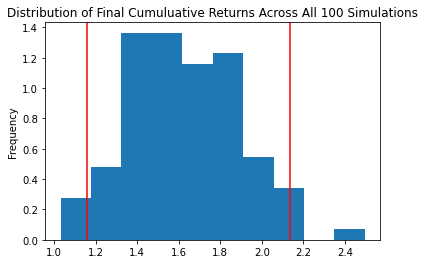

In [114]:
# Plotting distribrution and confidence intervals from Monte Carlo Simulation
# This is the plot for the simulations using the individual stocks within ARKK and can be manipulated...
# this plot will be variable whereas the 'ARKK' and 'QQQ' PLOT
arkk_intial_distribution_plot = mcf.plot_distribution(portfolio_initial_sim_input)

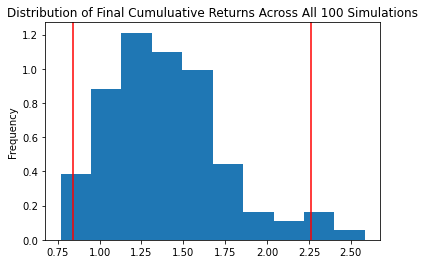

In [115]:
qqq_distribution_plot = mcf.plot_distribution(qqq_sim_input)

In [116]:
# Describe the MCForecast Summary
arkk_initial_simulation_summary = mcf.get_monte_summary(portfolio_initial_sim_input)
qqq_simulation_summary = mcf.get_monte_summary(qqq_sim_input)
display(arkk_initial_simulation_summary)
display(qqq_simulation_summary)

count           100.000000
mean              1.627251
std               0.263859
min               1.030495
25%               1.439581
50%               1.605524
75%               1.797524
max               2.495650
95% CI Lower      1.159906
95% CI Upper      2.134786
Name: 252, dtype: float64

count           100.000000
mean              1.381400
std               0.352870
min               0.766943
25%               1.149767
50%               1.343563
75%               1.549013
max               2.583326
95% CI Lower      0.839689
95% CI Upper      2.259562
Name: 252, dtype: float64

### We should get to this point after running our initial script -- The initial analyses should and plots should remain static while we generate variable plots and analyses based on the users changes.